In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46392 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:44950 Dashboard: http://127.0.0.1:46392/status,Cluster Workers: 24 Cores: 168 Memory: 754.89 GiB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [4]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

percent = 10
nmemb = 100

In [5]:
ver = 2
ds = xr.open_dataset(op.join(rund, 'outdir_%04d/vars.nc' % ver))
time = ds.t.data
ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds.coords['time'] = ('time',time)
# ds.coords['timeC'] = ('timeC',.5*(time[1:] + time[:-1]))
ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))

ds = ds.chunk({'time':10,'Z':-1,'Zp1':-1,
               'YC':128,'XC':128,'YG':128,'XG':128}
             )
    
# ds.to_zarr(op.join(rund,'spin-up/vars%03d/' % (ver-1)), mode='w')
ds

<xarray.Dataset>
Dimensions:  (XC: 1024, XG: 1024, YC: 1024, YG: 1024, Z: 3, Zp1: 4, time: 312)
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 308.0 309.0 310.0 311.0
  * YG       (YG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * XG       (XG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr0     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr1     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr2     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr3     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

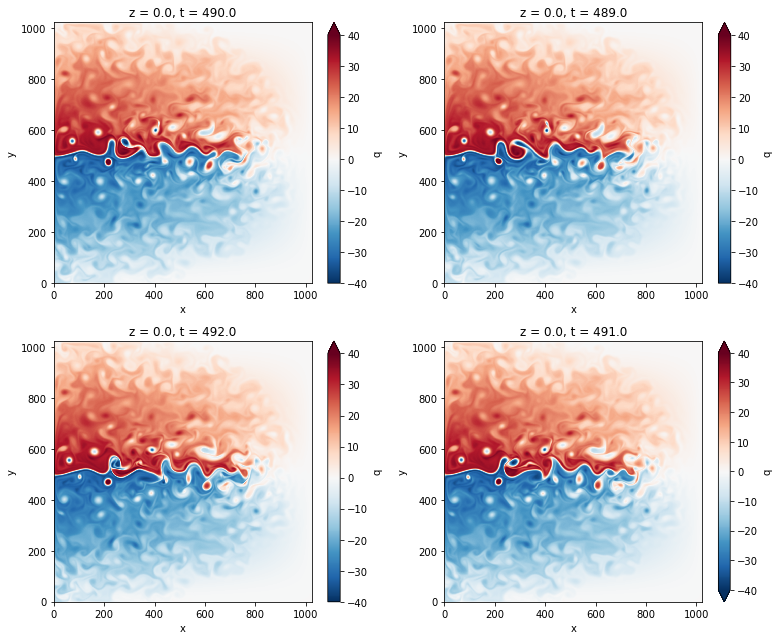

In [12]:
fig, axes = plt.subplots(figsize=(11,9), nrows=2, ncols=2)
fig.set_tight_layout(True)
xr.open_dataset(op.join(rund, 'ctrl/outdir_0001/vars.nc'),
               ).isel(t=-1,z=0).q.plot(ax=axes[0,0], vmax=4e1)
xr.open_dataset(op.join(rund, 'run000/outdir_0001/vars.nc'),
               ).isel(t=-1,z=0).q.plot(ax=axes[0,1], vmax=4e1)
xr.open_dataset(op.join(rund, 'run010/outdir_0001/vars.nc'),
               ).isel(t=-1,z=0).q.plot(ax=axes[1,0], vmax=4e1)
xr.open_dataset(op.join(rund, 'run020/outdir_0001/vars.nc'),
               ).isel(t=-1,z=0).q.plot(ax=axes[1,1], vmax=4e1)

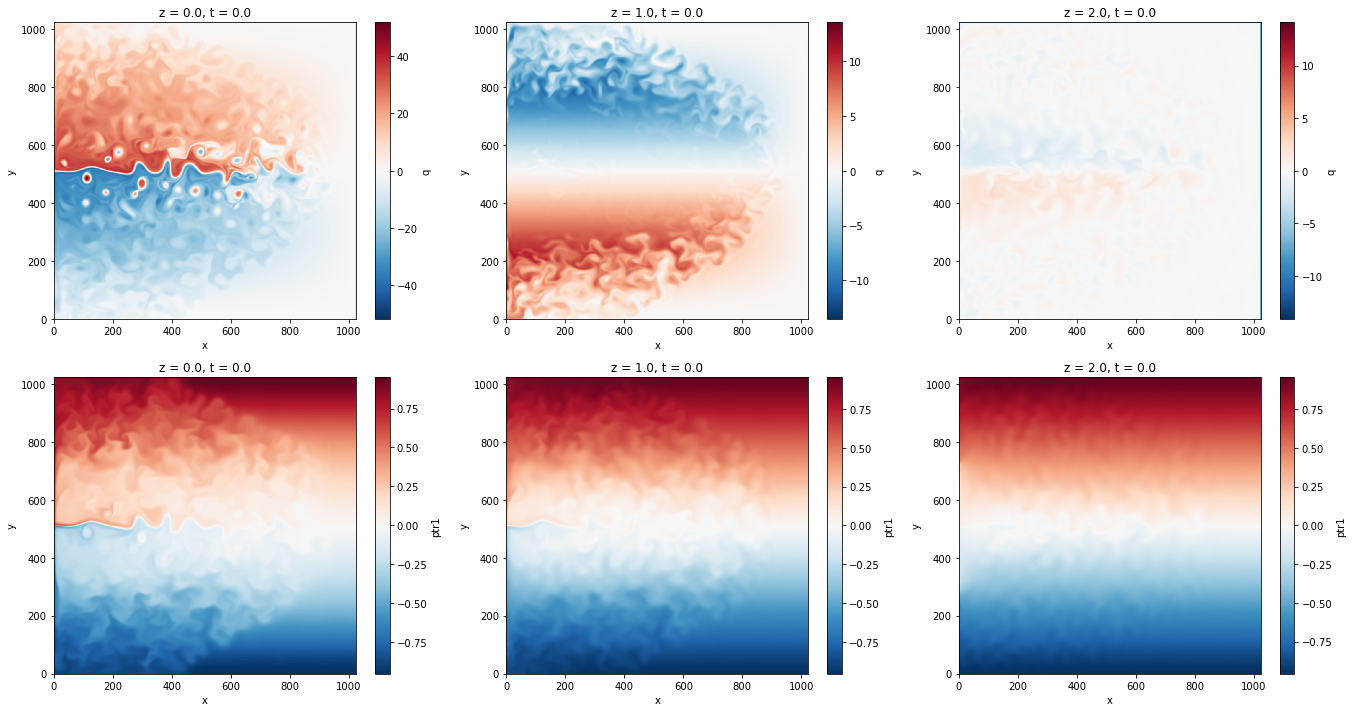

In [10]:
fig, axes = plt.subplots(figsize=(19,10), nrows=2, ncols=3)
fig.set_tight_layout(True)
xr.open_dataset(op.join(rund, 'run000/outdir_0001/vars.nc'),
               ).isel(t=0,z=0).q.plot(ax=axes[0,0])
xr.open_dataset(op.join(rund, 'run000/outdir_0001/vars.nc'),
               ).isel(t=0,z=1).q.plot(ax=axes[0,1])
xr.open_dataset(op.join(rund, 'run000/outdir_0001/vars.nc'),
               ).isel(t=0,z=2).q.plot(ax=axes[0,2])
xr.open_dataset(op.join(rund, 'run000/outdir_0001/vars.nc'),
               ).isel(t=0,z=0).ptr1.plot(ax=axes[1,0])
xr.open_dataset(op.join(rund, 'run000/outdir_0001/vars.nc'),
               ).isel(t=0,z=1).ptr1.plot(ax=axes[1,1])
xr.open_dataset(op.join(rund, 'run000/outdir_0001/vars.nc'),
               ).isel(t=0,z=2).ptr1.plot(ax=axes[1,2])

In [5]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd < 4:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
    
#     lap = (psi_padded[...,2:,1:-1] + psi_padded[...,:-2,1:-1] 
#            + psi_padded[...,1:-1,2:] + psi_padded[...,1:-1,:-2] 
#            - 4*psi_padded[...,1:-1,1:-1]
#           ) / Delta**2

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [6]:
ver = 2

for i in range(54,nmemb+1):
    if i < nmemb:
        ds = xr.open_dataset(op.join(rund, 'run%03d/outdir_%04d/vars.nc' % (i,ver+1)),
                            ).isel(t=slice(None,None))
    else:
        ds = xr.open_dataset(op.join(rund, 'ctrl/outdir_%04d/vars.nc' % (ver+1)),
                            ).isel(t=slice(None,312))

#     ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
    time = ds.t.data
    ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
    ds.coords['time'] = ('time',time+311*ver)
    # ds.coords['timeC'] = ('timeC',.5*(time[1:] + time[:-1]))
    ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
    ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
    ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
    ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
    ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
#     ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
    ds.coords['Zp1'] = ('Zp1',np.array([.06,.2]))
    ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
#     ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
    ds.coords['drC'] = ('Zp1',np.array([.1,.47]))
    
    psi_padded = xr.DataArray(pad_bc(ds.p.values), 
                              dims=['time','Z','Yp1','Xp1'],
                              coords={'time':ds.time.data,'Z':ds.Z.data,
                                      'Yp1':np.arange(-dx/2,L0+dx,dx),
                                      'Xp1':np.arange(-dx/2,L0+dx,dx)}
                             )
    p = (ds.drF.isel(Z=slice(1,None)).values[np.newaxis,:,np.newaxis,np.newaxis] 
         * ds.p.isel(Z=slice(None,-1)).values
         + ds.drF.isel(Z=slice(None,-1)).values[np.newaxis,:,np.newaxis,np.newaxis] 
         * ds.p.isel(Z=slice(1,None)).values
        ) / (ds.drF.isel(Z=slice(1,None)).values 
             + ds.drF.isel(Z=slice(None,-1)).values
            )[np.newaxis,:,np.newaxis,np.newaxis]
    psip1_padded = xr.DataArray(pad_bc(p), 
                                dims=['time','Zp1','Yp1','Xp1'],
                                coords={'time':ds.time.data,'Zp1':ds.Zp1.data,
                                        'Yp1':np.arange(-dx/2,L0+dx,dx),
                                        'Xp1':np.arange(-dx/2,L0+dx,dx)}
                               )
    del p
    ds['psi'] = psi_padded
    ds['psip1'] = psip1_padded
    ds = ds.drop('p')
    ds = ds.chunk({'time':10,'Z':-1,'Zp1':-1,
                   'YC':100,'XC':100,'YG':100,'XG':100,
                   'Yp1':100,'Xp1':100}
                 )
    
    if i < nmemb:
        ds.to_zarr(op.join(rund,'run%03d/vars%03d/' % (i,ver)), mode='w')
    else:
        ds.to_zarr(op.join(rund,'ctrl/vars%03d/' % ver), mode='w')
        
    if i % 10 == 0:
        print(i,ds)
    ds.close()

60 <xarray.Dataset>
Dimensions:  (XC: 1024, XG: 1024, Xp1: 1026, YC: 1024, YG: 1024, Yp1: 1026, Z: 3, Zp1: 2, time: 312)
Coordinates:
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 622.0 623.0 624.0 625.0 ... 930.0 931.0 932.0 933.0
  * YG       (YG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * XG       (XG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * Zp1      (Zp1) float64 0.06 0.2
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
  * Yp1      (Yp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Xp1      (Xp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
Data variables:
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 100, 100), meta

In [6]:
nx = 100

for i in range(nmemb,nmemb+1):
    if i < nmemb:
        ds = xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/vars000' % i))
        psi_padded = xr.DataArray(pad_bc(ds.p.values), 
                                  dims=['time','Z','Yp1','Xp1'],
                                  coords={'time':ds.time.data,'Z':ds.Z.data,
                                          'Yp1':np.arange(-dx/2,L0+dx,dx),
                                          'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                 )
        p = (ds.drF.isel(Z=slice(1,None)).values[np.newaxis,:,np.newaxis,np.newaxis] 
             * ds.p.isel(Z=slice(None,-1)).values
             + ds.drF.isel(Z=slice(None,-1)).values[np.newaxis,:,np.newaxis,np.newaxis] 
             * ds.p.isel(Z=slice(1,None)).values
            ) / (ds.drF.isel(Z=slice(1,None)).values + ds.drF.isel(Z=slice(None,-1)).values
                )[np.newaxis,:,np.newaxis,np.newaxis]
        psip1_padded = xr.DataArray(pad_bc(p), 
                                    dims=['time','Zp1','Yp1','Xp1'],
                                    coords={'time':ds.time.data,
                                            'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                                            'Yp1':np.arange(-dx/2,L0+dx,dx),
                                            'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                   )
        del p
        dsave = psi_padded.to_dataset(name='psi')
        dsave['psip1'] = psip1_padded
        dsave = dsave.chunk({'time':10,'Yp1':nx,'Xp1':nx})
        dsave.to_zarr(op.join(ddir,'run%03d/10percent/Fr-sqrt3_Ekb-2/psi_padded/' % i), mode='w')
        ds.close()
        dsave.close()
    
    else:
        ds = xr.open_zarr(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/vars000'))
        psi_padded = xr.DataArray(pad_bc(ds.p.values), 
                                  dims=['time','Z','Yp1','Xp1'],
                                  coords={'time':ds.time.data,'Z':ds.Z.data,
                                          'Yp1':np.arange(-dx/2,L0+dx,dx),
                                          'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                 )
        p = (ds.drF.isel(Z=slice(1,None)).values[np.newaxis,:,np.newaxis,np.newaxis] 
             * ds.p.isel(Z=slice(None,-1)).values
             + ds.drF.isel(Z=slice(None,-1)).values[np.newaxis,:,np.newaxis,np.newaxis] 
             * ds.p.isel(Z=slice(1,None)).values
            ) / (ds.drF.isel(Z=slice(1,None)).values + ds.drF.isel(Z=slice(None,-1)).values
                )[np.newaxis,:,np.newaxis,np.newaxis]
        psip1_padded = xr.DataArray(pad_bc(p), 
                                    dims=['time','Zp1','Yp1','Xp1'],
                                    coords={'time':ds.time.data,'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                                            'Yp1':np.arange(-dx/2,L0+dx,dx),
                                            'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                   )
        del p
        dsave = psi_padded.to_dataset(name='psi')
        dsave['psip1'] = psip1_padded
        dsave = dsave.chunk({'time':10,'Yp1':nx,'Xp1':nx})
        dsave.to_zarr(op.join(ddir,'ctrl/10percent/Fr-sqrt3_Ekb-2/psi_padded/'), mode='w')
        ds.close()
        dsave.close()
        
    if i % 10 == 0:
        print(i)

100


In [5]:
for i in range(nmemb+1):
#     if i < nmemb:
#         ds = xr.open_dataset(op.join(ddir, 'run%02d/vars000.nc' % i))
#     else:
#         ds = xr.open_dataset(op.join(ddir, 'ctrl/vars000.nc'))
    if i < nmemb:
        ds = xr.open_dataset(op.join(ddir, 'run%03d/vars.nc' % i))
    else:
        ds = xr.open_dataset(op.join(ddir, 'ctrl/vars.nc'))
#     if i % 10 == 0:
#         print(i)

#     ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
    time = ds.t.data
    ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
    ds.coords['time'] = ('time',time)
    # ds.coords['timeC'] = ('timeC',.5*(time[1:] + time[:-1]))
    ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
    ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
    ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
    ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
    ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
    ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
    ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
    ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))

    ds = ds.chunk({'time':10,'Z':-1,'Zp1':-1,
                   'YC':128,'XC':128,'YG':128,'XG':128}
                 )
    
    if i < nmemb:
        ds.to_zarr(op.join(ddir,'run%03d/vars000/' % i), mode='w')
    else:
        ds.to_zarr(op.join(ddir,'ctrl/vars000/'), mode='w')
        
    ds.close()
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80


In [6]:
dtt = 7
ttstart = 34
ver = 2

for tt in range(ttstart,int(312/dtt)+1):
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                ds = xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                dsw = xr.open_zarr(op.join(rund, 'run%03d/W%03d_dN2dt' % (i,ver))
                                  ).isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                               ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                               ], 'nmemb')
                dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'run%03d/W%03d_dN2dt' % (i,ver))
                                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                                ], 'nmemb')
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'ctrl/vars%03d' % ver)
                                           ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                           ], 'nmemb')
            dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'ctrl/W%03d_dN2dt' % ver)
                                             ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                            ], 'nmemb')

    ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
    dsw.coords['nmemb'] = ('nmemb',range(nmemb+1))
#     ds = ds.chunk({'nmemb':-1})
#     dsw = dsw.chunk({'nmemb':-1})

    dsave = ds.psi.mean('nmemb').compute().to_dataset(name='psib')
    dsave['psip1b'] = ds.psip1.mean('nmemb').compute()
    dsave['wb'] = dsw.w.mean('nmemb').compute()
    dsave = dsave.drop_vars(['drC','drF']).chunk({'time':-1,'YC':128,'XC':128,
                                                  'Yp1':100,'Xp1':100})
    if tt == ttstart:
        print(dsave)
    dsave.to_zarr(op.join(rund,'Mean%03d/%03d-%03d/' 
                          % (ver,tt*dtt,tt*dtt+len(ds.time)-1)), mode='w'
                 )
    dsave.close()
    dsw.close()
    ds.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, Xp1: 1026, YC: 1024, Yp1: 1026, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * Xp1      (Xp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Yp1      (Yp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 860.0 861.0 862.0 863.0 864.0 865.0 866.0
  * Zp1      (Zp1) float64 0.06 0.2
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    psib     (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    psip1b   (time, Zp1, Yp1, Xp1) float64 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    wb       (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
34


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

35
36
37
38
39
40
41
42
43
44


In [6]:
dtt = 7
ttstart = 32
ver = 2

for tt in range(ttstart,int(312/dtt)+1):
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                ds = xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                dsw = xr.open_zarr(op.join(rund, 'run%03d/W%03d_dN2dt' % (i,ver))
                                  ).isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                               ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                               ], 'nmemb')
                dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'run%03d/W%03d_dN2dt' % (i,ver))
                                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                                ], 'nmemb')
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'ctrl/vars%03d' % ver)
                                           ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                           ], 'nmemb')
            dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'ctrl/W%03d_dN2dt' % ver)
                                             ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                            ], 'nmemb')

    ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
    dsw.coords['nmemb'] = ('nmemb',range(nmemb+1))
    
    dsb = xr.open_zarr(op.join(rund,"Mean%03d/%03d-%03d" 
                               % (ver,tt*dtt,tt*dtt+len(ds.time)-1))
                      )
    psip = ds.psi - dsb.psib
    psip1p = ds.psip1 - dsb.psip1b
    wp = dsw.w - dsb.wb
    
    dsave = psip.to_dataset(name='psip')
    dsave['psip1p'] = psip1p
    dsave['wp'] = wp
    dsave = dsave.drop_vars(['drC','drF']).chunk({'time':-1,'YC':128,'XC':128,
                                                  'Yp1':100,'Xp1':100})
    if tt == ttstart:
        print(dsave)
    dsave.to_zarr(op.join(rund,'Eddy%03d/%03d-%03d/' 
                          % (ver,tt*dtt,tt*dtt+len(ds.time)-1)), mode='w'
                 )
    dsave.close()
    dsw.close()
    ds.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, Xp1: 1026, YC: 1024, Yp1: 1026, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1      (Xp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Yp1      (Yp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 846.0 847.0 848.0 849.0 850.0 851.0 852.0
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * Zp1      (Zp1) float64 0.06 0.2
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    psip     (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    psip1p   (nmemb, time, Zp1, Yp1, Xp1) float64 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>
    wp       (nmemb, time, Zp1, YC, XC) float64 dask.array<chunksize=(1, 7, 2, 128, 128), meta=np.ndarray>


distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:46540
Traceback (most recent call last):
  File "/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/site-packages/distributed/comm/core.py", line 285, in connect
    comm = await asyncio.wait_for(
  File "/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/asyncio/tasks.py", line 501, in wait_for
    raise exceptions.TimeoutError()
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/site-packages/distributed/worker.py", line 2259, in gather_dep
    response = await get_data_from_worker(
  File "/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/site-packages/distributed/worker.py", line 3566, in get_data_from_worker
    return await retry_operation(_get_data, operation="get_data_from_worker")
  File "/scratch/cnt0024/hmg2840/tuchida/env

32
33
34
35
36
37
38
39
40
41
42
43
44


In [5]:
dtt = 7
ttstart = 0
ver = 2

for tt in range(ttstart,int(312/dtt)+1):
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                ds = xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                               ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                               ], 'nmemb')
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'ctrl/vars%03d' % ver)
                                           ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                           ], 'nmemb')

    ds.coords['nmemb'] = ('nmemb',range(nmemb+1))

    dsave = ds.ptr0.mean('nmemb').compute().to_dataset(name='ptr0b')
    dsave['ptr1b'] = ds.ptr1.mean('nmemb').compute()
    dsave['ptr2b'] = ds.ptr2.mean('nmemb').compute()
    dsave['ptr3b'] = ds.ptr3.mean('nmemb').compute()
    dsave = dsave.drop_vars('drF').chunk({'time':-1,'YC':128,'XC':128})
    if tt == ttstart:
        print(dsave)
    dsave.to_zarr(op.join(rund,'MeanPTR%03d/%03d-%03d/' 
                          % (ver,tt*dtt,tt*dtt+len(ds.time)-1)), mode='w'
                 )
    dsave.close()
    ds.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 622.0 623.0 624.0 625.0 626.0 627.0 628.0
Data variables:
    ptr0b    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    ptr1b    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    ptr2b    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    ptr3b    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
0


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

1


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

2


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

3


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

4


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

5


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


22


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

23
24
25
26
27
28
29
30
31
32
33
34
35
36


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


37


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


38


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

39


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


40


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


41


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

42


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

43


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44


In [5]:
dtt = 7
ttstart = 35
ver = 2

for tt in range(ttstart,int(312/dtt)+1):
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                ds = xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                               ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                               ], 'nmemb')
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'ctrl/vars%03d' % ver)
                                           ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                           ], 'nmemb')

    ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
    
    dsb = xr.open_zarr(op.join(rund,"MeanPTR%03d/%03d-%03d" 
                               % (ver,tt*dtt,tt*dtt+len(ds.time)-1))
                      )
    
    dsave = (ds.ptr0 - dsb.ptr0b).to_dataset(name='ptr0p')
    dsave['ptr1p'] = ds.ptr1 - dsb.ptr1b
    dsave['ptr2p'] = ds.ptr2 - dsb.ptr2b
    dsave['ptr3p'] = ds.ptr3 - dsb.ptr3b
    dsave = dsave.drop_vars(['drF']).chunk({'time':-1,'YC':128,'XC':128})
    if tt == ttstart:
        print(dsave)
    dsave.to_zarr(op.join(rund,'EddyPTR%03d/%03d-%03d/' 
                          % (ver,tt*dtt,tt*dtt+len(ds.time)-1)), mode='w'
                 )
    dsave.close()
    ds.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, nmemb: 101, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 867.0 868.0 869.0 870.0 871.0 872.0 873.0
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
Data variables:
    ptr0p    (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 7, 3, 128, 128), meta=np.ndarray>
    ptr1p    (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 7, 3, 128, 128), meta=np.ndarray>
    ptr2p    (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 7, 3, 128, 128), meta=np.ndarray>
    ptr3p    (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 7, 3, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

35


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

36


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

37


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

38


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

39


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

40


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

41


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


42
43
44


In [7]:
client.close()